In [1]:
%config InlineBackend.figure_format = "svg"

from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

# Import data

In [2]:
# Path of the data
datapath = "data"

# Files to gather
files = glob(datapath + "/*.h5")

# Display all available files
print(files)

['data/wohg_hq1000.h5', 'data/hg3000_hq1400.h5', 'data/hg3000_hq1000.h5', 'data/wohg_hq1200.h5', 'data/wohg_hq1400.h5', 'data/fcnc.h5', 'data/hg3000_hq1200.h5', 'data/bkg.h5']


## Apply data-cuts

In [3]:
def cut_df(file: str, seed: int, sup_split:float):
    """
    A function that applies cuts to an .h5 or .csv data file.
    Returns a pandas dataframe.
    
    Data-cuts applied according to model transferability paper: https://arxiv.org/pdf/1912.04220.pdf
        - At least 2 final state leptons
        - At least 1 b-tagged jet
        - Must have a large scalar sum of transverse momentum (>500GeV)
    """
    
    # Assertions
    assert seed > 0, "Invalid seed."
    assert (sup_split) > 0 and (sup_split < 1), "Invalid split."
    
    # Read dataframe and sort indices
    df = pd.read_hdf(file)
    df = df.sort_index()
    
    # Initial size
    initial_size = len(df)
    
    # Apply data cuts
    df = df[(df["Electron_Multi"] + df["Muon_Multi"]) > 1]
    df = df[(df["Jet1_BTag"] + df["Jet2_BTag"] + df["Jet3_BTag"] + df["Jet4_BTag"] + df["Jet5_BTag"]) > 0]
    df = df[df["ScalarHT_HT"] > 500]
    cut_ratio = 100 * (initial_size - len(df)) / initial_size
    
    # Drop gen_split column (meta split is the only one needed)
    df = df.drop(columns=["gen_split"])
    
    # Meta split: support and query data
    df["gen_meta_split"] = "query"
    sample_indices = df.sample(frac=sup_split).index.values
    df.loc[sample_indices, "gen_meta_split"] = "sup"
    
    # Renormalize weights for the meta split
    for meta_split in ["sup", "query"]:
        mask = df["gen_meta_split"] == meta_split
        df.loc[mask, "gen_weights"] = df[mask]["gen_xsec"] / df[mask].shape[0]
    
    # Display cut ratio information
    filename = file.split("/")[-1].split(".")[0]
    print(f"File: {filename} | Drop ratio: {cut_ratio}%")
    
    return df

In [4]:
# Define data parameters
data_dict = {}
random_seed = 42
sup_split = 0.3

# Populate data dict
columns = []
for file in tqdm(files, total=len(files), desc="Processing data"):
    # Insert data into dictionary
    filename = file.split("/")[-1].split(".")[0]
    data_dict[filename] = cut_df(file, random_seed, sup_split)
    
    # Insert columns in column list
    columns.append(set(data_dict[filename].columns.to_list()))

Processing data:  25%|██▌       | 2/8 [00:00<00:01,  4.99it/s]File: wohg_hq1000 | Drop ratio: 3.4287204223974967%
File: hg3000_hq1400 | Drop ratio: 2.1137614678899084%
Processing data:  50%|█████     | 4/8 [00:00<00:00,  5.82it/s]File: hg3000_hq1000 | Drop ratio: 2.443991853360489%
File: wohg_hq1200 | Drop ratio: 3.169875545154771%
Processing data:  88%|████████▊ | 7/8 [00:01<00:00,  4.99it/s]File: fcnc | Drop ratio: 0.0%
File: hg3000_hq1200 | Drop ratio: 2.3649893170264495%
Processing data: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]File: bkg | Drop ratio: 0.33191496821583044%



In [5]:
# Determine different columns along dataframes
union_set = set.union(*columns)
intersection_set = set.intersection(*columns)
drop_cols = list(union_set - intersection_set)

# Remove the different columns (so that the data all has the same features and shape)
for file in tqdm(files, total=len(files), desc="Removing extra columns"):
    filename = file.split("/")[-1].split(".")[0]
    data_dict[filename] = data_dict[filename].drop(columns=drop_cols, errors="ignore")
    assert len(data_dict[filename].columns.to_list()) == len(intersection_set), "Number of columns is wrong"

Removing extra columns: 100%|██████████| 8/8 [00:00<00:00, 56.07it/s]


In [6]:
len([col for col in intersection_set if "gen" not in col])

69

In [7]:
# Split background according to the different tasks
signal_files = [f.split("/")[-1].split(".")[0] for f in files if "bkg" not in f]

# Iterate through the tasks to find their length and how much background should go to each
# This is done by weighting their sizes and normalizing weights
signal_weights = {signal: len(data_dict[signal]) for signal in signal_files}
total = sum(list(signal_weights.values()))
for key in signal_weights:
    signal_weights[key] /= total

# Calculate background size
df = data_dict["bkg"]
sup_bkg_size = len(df[df["gen_meta_split"] == "sup"])
que_bkg_size = len(df[df["gen_meta_split"] == "query"])

# Create a dictionary of cummulative sizes for each task
sup_signal_sizes = {signal: int(sup_bkg_size*signal_weights[signal]) for signal in signal_weights}
sup_signal_sizes["fcnc"] += (sup_bkg_size - sum(list(sup_signal_sizes.values())))
que_signal_sizes = {signal: int(que_bkg_size*signal_weights[signal]) for signal in signal_weights}
que_signal_sizes["fcnc"] += (que_bkg_size - sum(list(que_signal_sizes.values())))
sup_sum, que_sum = 0, 0
for key in sup_signal_sizes:
    sup_tmp, que_tmp = sup_signal_sizes[key], que_signal_sizes[key]
    sup_signal_sizes[key] += sup_sum
    que_signal_sizes[key] += que_sum
    sup_sum, que_sum = sup_sum + sup_tmp, que_sum + que_tmp

In [8]:
# Create new column and populate it
sup_df = df[df["gen_meta_split"]=="sup"].sample(frac=1).reset_index()
que_df = df[df["gen_meta_split"]=="query"].sample(frac=1).reset_index()
sup_start, que_start = 0, 0
for signal in sup_signal_sizes:
    sup_end, que_end = sup_signal_sizes[signal], que_signal_sizes[signal]
    sup_df.loc[sup_start:sup_end, "gen_task"] = signal
    que_df.loc[que_start:que_end, "gen_task"] = signal
    sup_start, que_start = sup_end, que_end
data_dict["bkg"] = pd.concat([sup_df, que_df], ignore_index=True).reset_index()

## Plot the data

In [9]:
def plot_histograms(plot_dict, files: [(str, str)], scale="log", bins=50):
    """
    A function that draws the histograms of the data
    """
    
    # Assertions
    assert len(files) > 0, "Choose at least one file to plot"
    
    # Select the correct data splits
    data_dict = {}
    for file, meta_split in files:
        df = plot_dict[file]
        if meta_split != "all": df = df[df["gen_meta_split"] == meta_split]
        data_dict[f"{file} {meta_split}"] = df
    files = [f"{file[0]} {file[1]}" for file in files]
        
    # Get features to plot
    drop_cols = [col for col in data_dict[files[0]].columns.to_list() if "gen" in col]
    features = data_dict[files[0]].drop(columns=drop_cols).columns.to_list()
    
    # Define rows and columns for subplot
    columns = 5
    rows = int(np.ceil(len(features)/columns))
    
    # Create axis
    fig, axs = plt.subplots(rows, columns, figsize=(40, 60))
    
    # Plot every feature
    for i, feature in enumerate(features):
        # Define histogram range
        hist_min = min([data_dict[file][feature].min() for file in files])
        hist_max = max([data_dict[file][feature].max() for file in files])
        hist_range = (hist_min, hist_max)

        # Adjust plot axis
        row, col = i // columns, i % columns
        axs[row, col].set_title(features[i])
        axs[row, col].set_yscale(scale)
        
        # Plot histogram for each file 
        for file in files:
            axs[row, col].hist(data_dict[file][feature], bins=bins, label=file, alpha=0.8, range=hist_range,
                               weights=data_dict[file]["gen_weights"], histtype='step')
        axs[row, col].legend()
    plt.show()

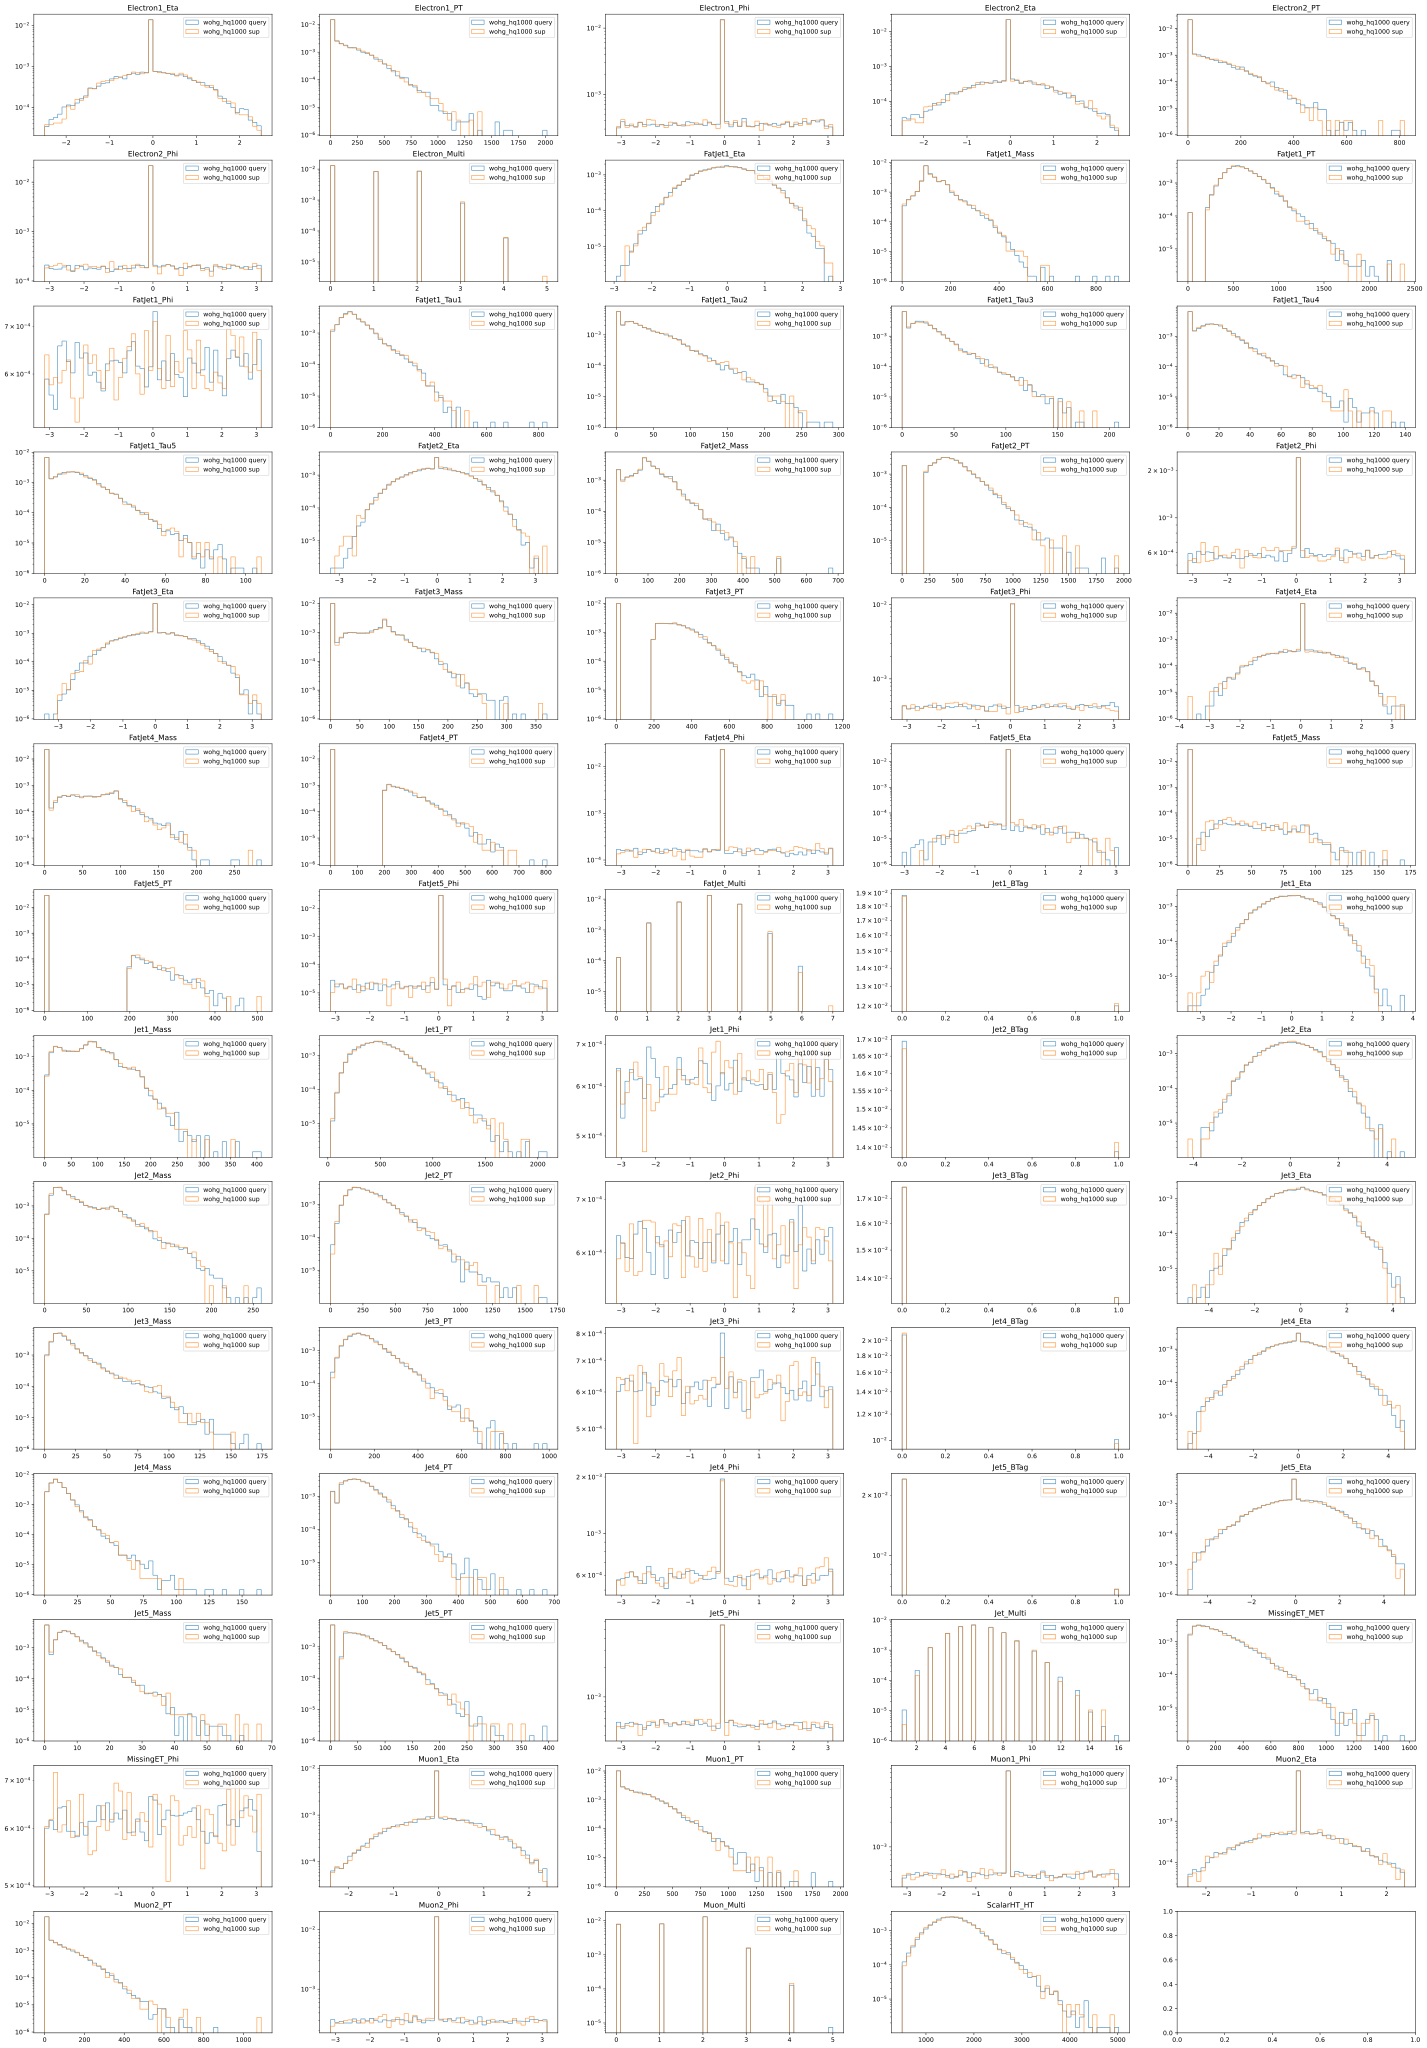

In [10]:
# Plot arguments
plot_files = [("wohg_hq1000", "query"), ("wohg_hq1000", "sup")]
scale = "log"
bins = 50

# Plot the histograms
plot_histograms(data_dict, plot_files, scale, bins)

### Save processed data as .h5 files

In [11]:
savepath = "processed-data/"
for filename in data_dict:
    data_dict[filename].to_hdf(savepath + filename + ".h5", key="df")

# DataSet Class

In [12]:
class MetaHEPDataset(Dataset):
    """
    A Dataset class for the processed .h5 files.
    Each entry of the dataset contains a tuple of (features, weight, label).
    """
    def __init__(self, signal_path, bkg_path, meta_split):
        # NOTE: BKG HAS NO SAMPLE MATCHING FCNC
        
        # Load and store the data
        signal = signal_path.split("/")[-1].split(".")[0]
        signal_df = pd.read_hdf(signal_path)
        bkg_df = pd.read_hdf(bkg_path)
        bkg_df = bkg_df[bkg_df["gen_task"] == signal]
        df = pd.concat([signal_df, bkg_df], ignore_index=True)
        mask = df["gen_meta_split"] == meta_split
        self.df = df[mask].reset_index(drop=True)
        
        # Store weights
        self.weights = self.df["gen_xsec"] / self.df.shape[0]
        
        # Store labels
        self.df["gen_label"] = self.df["gen_label"].replace({"bkg": 0.0, "signal": 1.0})
        self.labels = self.df["gen_label"]
        
        # Drop gen columns of dataframe
        drop_cols = [col for col in self.df if "gen" in col] + ["level_0", "index"]
        self.df = self.df.drop(columns=drop_cols)
        
    def get_class_weights(self):
        signal_events = self.labels[self.labels == 1].shape[0]
        bkg_events = self.labels[self.labels == 0].shape[0]
        signal_weight = bkg_events / signal_events
        class_weights = torch.tensor([1, signal_weight]).float()
        return class_weights
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        features = torch.tensor(self.df.loc[idx, :].values).float()
        weight = torch.tensor(self.weights.loc[idx]).float()
        label = torch.tensor(self.labels.loc[idx]).float()
        return features, weight, label

# Create Tasks from Datasets

In [13]:
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def generate_tasks(signal_files, bkg_file, sup_shots, que_shots):
    """
    A function that generates a group of tasks (number of tasks equals number of signal files)
    The return of the function is a dictionary of tasks:
        - Keys are the task's filename
        - Values are a dictionary:
            - Keys are "sup" and "que", relative to the support and query data
            - Values are PyTorch dataloaders
    """
    # Create task dict
    tasks = {}
    
    # Create the different tasks in the dictionary
    for file in tqdm(signal_files, total=len(signal_files), desc="Populating tasks"):
        # Get filename of the corresponding file
        filename = file.split("/")[-1].split(".")[0]

        # Create support and query DataLoaders for the signal file
        sup_set = MetaHEPDataset(file, bkg_file, "sup")
        que_set = MetaHEPDataset(file, bkg_file, "query")
        sup_loader = DataLoader(sup_set, batch_size=sup_shots, shuffle=True)
        que_loader = DataLoader(que_set, batch_size=que_shots, shuffle=True)

        # Add the dataloaders to the dictionary
        tasks[filename] = {"sup": {}, "que": {}}
        tasks[filename]["sup"]["data"] = iter(cycle(sup_loader))
        tasks[filename]["sup"]["weights"] = sup_set.get_class_weights()
        tasks[filename]["que"]["data"] = iter(cycle(que_loader))
        tasks[filename]["que"]["weights"] = que_set.get_class_weights()
        
    return tasks

In [14]:
# Datapath and background file
datapath = "processed-data/"
bkg_file = datapath + "bkg.h5"

# Signal files for each split
train_signals = ["hg3000_hq1000", "hg3000_hq1400", "wohg_hq1200"]
val_signals = ["hg3000_hq1200", "wohg_hq1000"]
test_signals = ["wohg_hq1400", "fcnc"]

# Add datapath and extention to files for each split
train_signals = [datapath + p + ".h5" for p in train_signals]
val_signals = [datapath + p + ".h5" for p in val_signals]
test_signals = [datapath + p + ".h5" for p in test_signals]

# Select parameters for task generation
sup_shots = 5
query_shots = 15
same_sample = False

# Generate tasks
train_tasks = generate_tasks(train_signals, bkg_file, sup_shots, query_shots)
val_tasks = generate_tasks(val_signals, bkg_file, sup_shots, query_shots)
test_tasks = generate_tasks(test_signals, bkg_file, sup_shots, query_shots)

Populating tasks: 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


In [15]:
# Training weights
for task in train_tasks:
    X_sup, _, _ = next(train_tasks[task]["sup"]["data"])
    X_que, _, _ = next(train_tasks[task]["que"]["data"])
    sup_weights, que_weights = train_tasks[task]["sup"]["weights"], train_tasks[task]["que"]["weights"]
    print(f"Task {task} sup weights: {sup_weights} | Input Shape: {X_sup.shape}")
    print(f"Task {task} que weights: {que_weights} | Input Shape: {X_que.shape}")
    
# Validation weights
for task in val_tasks:
    X_sup, _, _ = next(val_tasks[task]["sup"]["data"])
    X_que, _, _ = next(val_tasks[task]["que"]["data"])
    sup_weights, que_weights = val_tasks[task]["sup"]["weights"], val_tasks[task]["que"]["weights"]
    print(f"Task {task} sup weights: {sup_weights} | Input Shape: {X_sup.shape}")
    print(f"Task {task} que weights: {que_weights} | Input Shape: {X_que.shape}")

# Test weights
for task in test_tasks:
    X_sup, _, _ = next(test_tasks[task]["sup"]["data"])
    X_que, _, _ = next(test_tasks[task]["que"]["data"])
    sup_weights, que_weights = test_tasks[task]["sup"]["weights"], test_tasks[task]["que"]["weights"]
    print(f"Task {task} sup weights: {sup_weights} | Input Shape: {X_sup.shape}")
    print(f"Task {task} que weights: {que_weights} | Input Shape: {X_que.shape}")

Task hg3000_hq1000 sup weights: tensor([1.0000, 3.8503]) | Input Shape: torch.Size([5, 69])
Task hg3000_hq1000 que weights: tensor([1.0000, 3.8503]) | Input Shape: torch.Size([15, 69])
Task hg3000_hq1400 sup weights: tensor([1.0000, 3.8504]) | Input Shape: torch.Size([5, 69])
Task hg3000_hq1400 que weights: tensor([1.0000, 3.8503]) | Input Shape: torch.Size([15, 69])
Task wohg_hq1200 sup weights: tensor([1.0000, 3.8501]) | Input Shape: torch.Size([5, 69])
Task wohg_hq1200 que weights: tensor([1.0000, 3.8504]) | Input Shape: torch.Size([15, 69])
Task hg3000_hq1200 sup weights: tensor([1.0000, 3.8503]) | Input Shape: torch.Size([5, 69])
Task hg3000_hq1200 que weights: tensor([1.0000, 3.8503]) | Input Shape: torch.Size([15, 69])
Task wohg_hq1000 sup weights: tensor([1.0000, 3.8503]) | Input Shape: torch.Size([5, 69])
Task wohg_hq1000 que weights: tensor([1.0000, 3.8503]) | Input Shape: torch.Size([15, 69])
Task wohg_hq1400 sup weights: tensor([1.0000, 3.8503]) | Input Shape: torch.Size([5